In [23]:
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [24]:
PICKLES_ADDRESS = '../data/pickles/'
LAG_DATA_ADDRESS = 'lag_data/'
TEMP_ADDRESS = 'temp/'

In [3]:
UMAP = True
LOADING_PARAM = True

if UMAP:
    TVD_ADDRESS = TEMP_ADDRESS + 'parallel/UMAP/TVDs/'
    JSD_ADDRESS = TEMP_ADDRESS + 'parallel/UMAP/JSDs/'
    HLD_ADDRESS = TEMP_ADDRESS + 'parallel/UMAP/HLDs/'
else:
    TVD_ADDRESS = '../data/parallel/TVDs/'
    JSD_ADDRESS = '../data/parallel/JSDs/'
    HLD_ADDRESS = '../data/parallel/HLDs/'

print('TVD_ADDRESS: ', TVD_ADDRESS)
print('JSD_ADDRESS: ', JSD_ADDRESS)
print('HLD_ADDRESS: ', HLD_ADDRESS)

TVD_ADDRESS:  temp/parallel/UMAP/TVDs/
JSD_ADDRESS:  temp/parallel/UMAP/JSDs/
HLD_ADDRESS:  temp/parallel/UMAP/HLDs/


## Import Data

In [4]:
years = [str(year) for year in range(2010, 2022)]
correlation_lags = [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7, 8, 9, 10, 11]
print('years:', years)

years: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [5]:
with open(PICKLES_ADDRESS + 'dui2children.pkl', 'rb') as handle:
    dui2children = pickle.load(handle)
    print('dui2children:', len(dui2children))
with open(PICKLES_ADDRESS + 'dui2trail_final.pkl', 'rb') as handle:
    dui2parents = pickle.load(handle)
    print('dui2parents:', len(dui2parents))
with open(PICKLES_ADDRESS + 'heading2dui_final.pkl', 'rb') as handle:
    dui2name = pickle.load(handle)
    print('dui2name:', len(dui2name))
with open(PICKLES_ADDRESS + 'dui2header_final.pkl', 'rb') as handle:
    name2dui = pickle.load(handle)
    print('name2dui:', len(name2dui))
with open(PICKLES_ADDRESS + 'dui2level_final.pkl', 'rb') as handle:
    dui2level = pickle.load(handle)
    print('dui2level:', len(dui2level))
with open(PICKLES_ADDRESS + 'level2duis_final.pkl', 'rb') as handle:
    level2duis = pickle.load(handle)
    print('level2duis:', len(level2duis))
with open(PICKLES_ADDRESS + 'dui2trail.pkl', 'rb') as handle:
    dui2trail = pickle.load(handle)
    print('dui2trail:', len(dui2trail))
with open(PICKLES_ADDRESS + 'dui_intersection_final.pkl', 'rb') as handle:
    dui_intersections = pickle.load(handle)
    print('dui_intersections:', len(dui_intersections))
with open(PICKLES_ADDRESS + 'excluded_duis_final.pkl', 'rb') as handle:
    excluded_duis = pickle.load(handle)
    print('excluded_duis:', len(excluded_duis))
with open(PICKLES_ADDRESS + 'dui2pubfreq.pkl', 'rb') as handle:
    dui2pubfreq = pickle.load(handle)
    print('dui2pubfreq:', len(dui2pubfreq))
with open(PICKLES_ADDRESS + 'dui2sbfreq.pkl', 'rb') as handle:
    dui2sbfreq = pickle.load(handle)
    print('dui2sbfreq:', len(dui2sbfreq))
with open(PICKLES_ADDRESS + 'dui2pubfreqchild.pkl', 'rb') as handle:
    dui2pubfreqchild = pickle.load(handle)
    print('dui2pubfreqchild:', len(dui2pubfreqchild))
with open(PICKLES_ADDRESS + 'dui2sbfreqchild.pkl', 'rb') as handle:
    dui2sbfreqchild = pickle.load(handle)
    print('dui2sbfreqchild:', len(dui2sbfreqchild))
with open(TEMP_ADDRESS + 'dui2pubcit.pkl', 'rb') as handle:
    dui2pubcit = pickle.load(handle)
    print('dui2pubcit:', len(dui2pubcit))
with open(TEMP_ADDRESS + 'dui2sbcit.pkl', 'rb') as handle:
    dui2sbcit = pickle.load(handle)
    print('dui2sbcit:', len(dui2sbcit))
with open(TEMP_ADDRESS + 'dui2pubcitchild.pkl', 'rb') as handle:
    dui2pubcitchild = pickle.load(handle)
    print('dui2pubcitchild:', len(dui2pubcitchild))
with open(TEMP_ADDRESS + 'dui2sbcitchild.pkl', 'rb') as handle:
    dui2sbcitchild = pickle.load(handle)
    print('dui2sbcitchild:', len(dui2sbcitchild))

dui2children: 29432
dui2parents: 29307
dui2name: 29307
name2dui: 29307
dui2level: 29307
level2duis: 14
dui2trail: 29432
dui_intersections: 29307
excluded_duis: 723
dui2pubfreq: 29307
dui2sbfreq: 29307
dui2pubfreqchild: 29307
dui2sbfreqchild: 29307
dui2pubcit: 29307
dui2sbcit: 29307
dui2pubcitchild: 29307
dui2sbcitchild: 29307


In [6]:
# store all duis that have no frequency at any year of the dui2pubfreq dictionary and store them in a list called exduis
exduis = {}
for dui in dui2sbfreq:
    c = 0
    for year in years:
        c += len(dui2sbfreq[dui][year])
    if c == 0:
        exduis[dui] = True
    else:
        exduis[dui] = False

len(exduis)

29307

In [7]:
# count how many excuis have False and True values
c = 0
incduis = []
dui2tensoridx = {}
tensoridx2dui = {}
for dui in exduis:
    if exduis[dui] == False:
        incduis.append(dui)
        dui2tensoridx[dui] = c
        tensoridx2dui[c] = dui
        c += 1
print(c, 'DUIs remained.', len(incduis), len(dui2tensoridx), len(tensoridx2dui))

10873 DUIs remained. 10873 10873 10873


In [8]:
if not LOADING_PARAM:
    #make three numpy array with size c, 12, 12 and name them tensor_TVD, tensor_JSD, tensor_HLD
    tensor_TVD = np.ones((c, 12, 12))
    tensor_JSD = np.ones((c, 12, 12))
    tensor_HLD = np.ones((c, 12, 12))

    # for each dui in exduis, load the corresponding TVD, JSD and HLD txt files and store them in the tensors
    c = 0
    for i, dui in tqdm(enumerate(incduis)):
        for pm_year_idx, pm_year in enumerate(years):
            for sb_year_idx, sb_year in enumerate(years):
                try:
                    tensor_TVD[i, pm_year_idx, sb_year_idx] = np.loadtxt(TVD_ADDRESS + '{}_{}_{}_TVD.txt'.format(dui, pm_year, sb_year))
                    tensor_JSD[i, pm_year_idx, sb_year_idx] = np.loadtxt(JSD_ADDRESS + '{}_{}_{}_JSD.txt'.format(dui, pm_year, sb_year))
                    tensor_HLD[i, pm_year_idx, sb_year_idx] = np.loadtxt(HLD_ADDRESS + '{}_{}_{}_HLD.txt'.format(dui, pm_year, sb_year))
                except:
                     pass
    #save the tensors in data/pickles
    if UMAP:
        with open(PICKLES_ADDRESS + 'tensor_UMAP_TVD.pkl', 'wb') as handle:
            pickle.dump(tensor_TVD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'tensor_UMAP_JSD.pkl', 'wb') as handle:
            pickle.dump(tensor_JSD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'tensor_UMAP_HLD.pkl', 'wb') as handle:
            pickle.dump(tensor_HLD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Tensors saved.')
    else:
        with open(PICKLES_ADDRESS + 'tensor_PCA_TVD.pkl', 'wb') as handle:
            pickle.dump(tensor_TVD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'tensor_PCA_JSD.pkl', 'wb') as handle:
            pickle.dump(tensor_JSD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'tensor_PCA_HLD.pkl', 'wb') as handle:
            pickle.dump(tensor_HLD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Tensors saved.')
else:
    print('Loading tensors...')
    if UMAP:
        with open(PICKLES_ADDRESS + 'tensor_UMAP_TVD.pkl', 'rb') as handle:
            TVD_diffs = pickle.load(handle)
        with open(PICKLES_ADDRESS + 'tensor_UMAP_JSD.pkl', 'rb') as handle:
            JSD_diffs = pickle.load(handle)
        with open(PICKLES_ADDRESS + 'tensor_UMAP_HLD.pkl', 'rb') as handle:
            HLD_diffs = pickle.load(handle)
    else:
        #load the tensors
        with open(PICKLES_ADDRESS + 'tensor_PCA_TVD.pkl', 'rb') as handle:
            TVD_diffs = pickle.load(handle)
        with open(PICKLES_ADDRESS + 'tensor_PCA_JSD.pkl', 'rb') as handle:
            JSD_diffs = pickle.load(handle)
        with open(PICKLES_ADDRESS + 'tensor_PCA_HLD.pkl', 'rb') as handle:
            HLD_diffs = pickle.load(handle)
    print(TVD_diffs.shape, JSD_diffs.shape, HLD_diffs.shape)

Loading tensors...
(10873, 12, 12) (10873, 12, 12) (10873, 12, 12)


In [9]:
#turn distance-containing tensors into similarity-containing tensors
tensor_TVD = 1 - TVD_diffs
tensor_JSD = 1 - JSD_diffs
tensor_HLD = 1 - HLD_diffs

print('tensor_TVD:', tensor_TVD.shape)
print('tensor_JSD:', tensor_JSD.shape)
print('tensor_HLD:', tensor_HLD.shape)

tensor_TVD: (10873, 12, 12)
tensor_JSD: (10873, 12, 12)
tensor_HLD: (10873, 12, 12)


In [10]:
def cal_triangular_ratio(score_matrix):
    ps_sims = []
    sp_sims = []
    for i in range(score_matrix.shape[0]):
        for j in range(score_matrix.shape[1]):
            sim = score_matrix[i, j]
            if j > i:
                ps_sims.append(sim)
            else:
                sp_sims.append(sim)
    return (np.sum(ps_sims) + 1) / (np.sum(sp_sims) + 1)

def cal_triangular_ratio_yearly(score_matrix):
    all_triangular_scores = {year: [] for year in years[:-1]}
    for idx, year in enumerate(years[:-1]):
        sub_matrix = score_matrix[idx:, idx:]
        triangular_ratio = cal_triangular_ratio(sub_matrix)
        all_triangular_scores[year] = triangular_ratio
    return all_triangular_scores

In [11]:
#calculate the triangular ratio for each dui
dui2tvdtr = {}
dui2jsdtr = {}
dui2hldtr = {}
for i in tqdm(range(len(tensor_TVD))):
    dui2tvdtr[tensoridx2dui[i]] = cal_triangular_ratio_yearly(tensor_TVD[i])
    dui2jsdtr[tensoridx2dui[i]] = cal_triangular_ratio_yearly(tensor_JSD[i])
    dui2hldtr[tensoridx2dui[i]] = cal_triangular_ratio_yearly(tensor_HLD[i])

100%|██████████| 10873/10873 [00:06<00:00, 1718.97it/s]


In [12]:
# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
max_depth = 13
tvd_std, jsd_std, hld_std = [], [], []
max_window_tvd_percents, max_window_jsd_percents, max_window_hld_percents = [], [], []
depth_wise_count = []

for depth in range(max_depth + 1):
    dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level] if dui in dui2tvdtr]
    depth_wise_count.append(len(dui_subset))
    dui2tvdtr_yearly = {year: [] for year in years[:-1]}
    dui2jsdtr_yearly = {year: [] for year in years[:-1]}
    dui2hldtr_yearly = {year: [] for year in years[:-1]}
    for dui in dui_subset:
        if dui in incduis:
            for k, v in dui2tvdtr[dui].items():
                dui2tvdtr_yearly[k].append(v)
            for k, v in dui2jsdtr[dui].items():
                dui2jsdtr_yearly[k].append(v)
            for k, v in dui2hldtr[dui].items():
                dui2hldtr_yearly[k].append(v)

    yearly_pos, yearly_neg = [], []
    for k, v in dui2tvdtr_yearly.items():
        x1 = len([score for score in v if score > 1])
        x2 = len([score for score in v if score <= 1])
        yearly_pos.append(x1)
        yearly_neg.append(x2)
    yearly_pos_percentage, yearly_neg_percentage = [], []
    for pos, neg in zip(yearly_pos, yearly_neg):
        x1 = pos / (pos + neg + 0.000000001) * 100
        x2 = neg / (pos + neg + 0.000000001) * 100
        yearly_pos_percentage.append(x1)
        yearly_neg_percentage.append(x2)
    max_window_tvd_percents.append(yearly_pos_percentage[0])
    tvd_std.append(np.std(yearly_pos_percentage))

    yearly_pos, yearly_neg = [], []
    for k, v in dui2jsdtr_yearly.items():
        x1 = len([score for score in v if score > 1])
        x2 = len([score for score in v if score <= 1])
        yearly_pos.append(x1)
        yearly_neg.append(x2)
    yearly_pos_percentage, yearly_neg_percentage = [], []
    for pos, neg in zip(yearly_pos, yearly_neg):
        x1 = pos / (pos + neg + 0.000000001) * 100
        x2 = neg / (pos + neg + 0.000000001) * 100
        yearly_pos_percentage.append(x1)
        yearly_neg_percentage.append(x2)
    max_window_jsd_percents.append(yearly_pos_percentage[0])
    jsd_std.append(np.std(yearly_pos_percentage))

    yearly_pos, yearly_neg = [], []
    for k, v in dui2hldtr_yearly.items():
        x1 = len([score for score in v if score > 1])
        x2 = len([score for score in v if score <= 1])
        yearly_pos.append(x1)
        yearly_neg.append(x2)
    yearly_pos_percentage, yearly_neg_percentage = [], []
    for pos, neg in zip(yearly_pos, yearly_neg):
        x1 = pos / (pos + neg + 0.000000001) * 100
        x2 = neg / (pos + neg + 0.000000001) * 100
        yearly_pos_percentage.append(x1)
        yearly_neg_percentage.append(x2)
    max_window_hld_percents.append(yearly_pos_percentage[0])
    hld_std.append(np.std(yearly_pos_percentage))

In [13]:
depth_wise_count

[0,
 58,
 853,
 2976,
 5653,
 7880,
 9283,
 10019,
 10491,
 10714,
 10822,
 10853,
 10864,
 10873]

In [14]:
depth_wise_count = np.array(depth_wise_count[1:])
max_window_tvd_percents = np.array(max_window_tvd_percents[1:])
max_window_jsd_percents = np.array(max_window_jsd_percents[1:])
max_window_hld_percents = np.array(max_window_hld_percents[1:])
tvd_std = np.array(tvd_std[1:])
jsd_std = np.array(jsd_std[1:])
hld_std = np.array(hld_std[1:])

In [15]:
tvd_error_max = np.minimum(max_window_tvd_percents + tvd_std, 99.9) - max_window_tvd_percents
jsd_error_max = np.minimum(max_window_jsd_percents + jsd_std, 99.9) - max_window_jsd_percents
hld_error_max = np.minimum(max_window_hld_percents + hld_std, 99.9) - max_window_hld_percents

tvd_error_max[0] + max_window_tvd_percents[0]

99.9

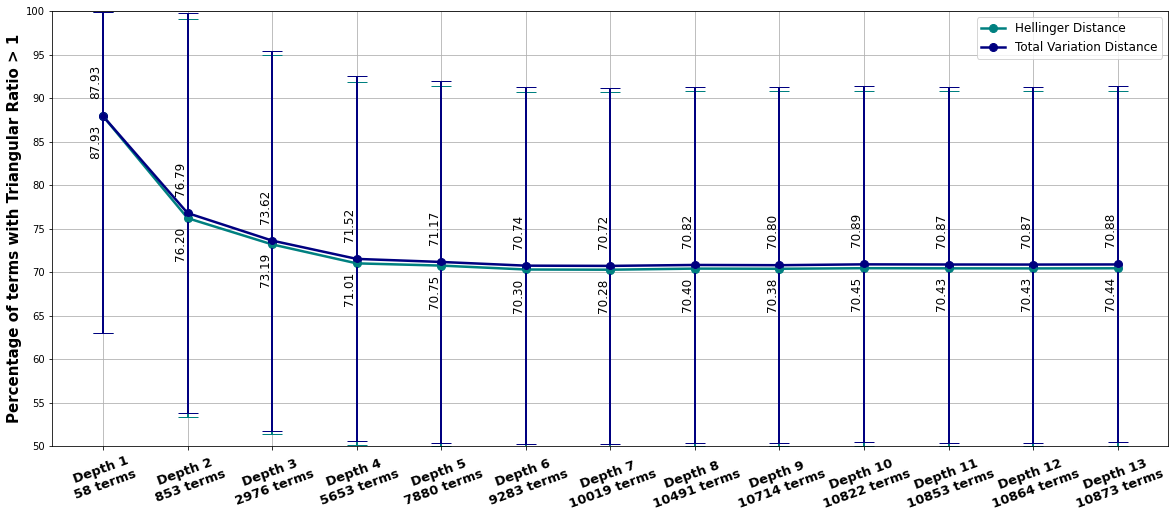

In [16]:
import matplotlib.pyplot as plt

x = ['Depth ' + str(depth + 1) + '\n' + str(each) + ' terms' for depth, each in enumerate(depth_wise_count)]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

# Error bounds for Hellinger Distance
ax.errorbar(x, max_window_hld_percents, yerr=[hld_std, hld_error_max], fmt='o', ecolor='teal', elinewidth=2, capsize=10, color='teal')
line3, = ax.plot(x, max_window_hld_percents, marker='o', color='teal', linewidth=2.5, markersize=8, label='Hellinger Distance')

# Error bounds for Total Variation Distance
ax.errorbar(x, max_window_tvd_percents, yerr=[tvd_std, tvd_error_max], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')
line1, = ax.plot(x, max_window_tvd_percents, marker='o', color='navy', linewidth=2.5, markersize=8, label='Total Variation Distance')

ax.grid(True)  # Add gridlines
ax.set_ylabel('Percentage of terms with Triangular Ratio > 1', fontsize=15, weight='bold')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation=20, fontsize=13, weight='bold')
ax.set_yticks(range(50, 101, 5))  # Set y-axis ticks from 50 to 100 in steps of 10
ax.set_ylim(50, 100)  # Set y-axis limits from 50% to 100%

# Add annotations for the first line
for i, val in enumerate(max_window_tvd_percents):
    val_formatted = '{:.2f}'.format(val)
    ax.annotate(f'{val_formatted}', (i, val), textcoords="offset points", xytext=(-7, 20), ha='center', fontsize=12, color='black', rotation=90)

# Add annotations for the third line
for i, val in enumerate(max_window_hld_percents):
    val_formatted = '{:.2f}'.format(val)
    ax.annotate(f'{val_formatted}', (i, val), textcoords="offset points", xytext=(-7, -40), ha='center', fontsize=12, color='black', rotation=90)

plt.legend(loc='upper right', fontsize='large')  # Add legend
if UMAP:
    plt.savefig('tvd_jsd_hld_umap.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('tvd_jsd_hld_pca.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
#save the plot information in a dataframe and save it in data/pickles
df = pd.DataFrame({'depth': range(1, max_depth + 1), 'tvd': max_window_tvd_percents, 'jsd': max_window_jsd_percents, 'hld': max_window_hld_percents, 'tvd_std': tvd_std, 'jsd_std': jsd_std, \
                   'hld_std': hld_std, 'tvd_error_max': tvd_error_max, 'jsd_error_max': jsd_error_max, 'hld_error_max': hld_error_max, 'count': depth_wise_count})
if UMAP:
    address = PICKLES_ADDRESS + 'tvd_jsd_hld_umap_results.pkl'
    df.to_pickle(address)
else:
    address = PICKLES_ADDRESS + 'tvd_jsd_hld_pca_results.pkl'
    df.to_pickle(address)

print('saved', address)

saved ../data/pickles/tvd_jsd_hld_umap_results.pkl


In [18]:
#load both dataframes and plot them together
with open(PICKLES_ADDRESS + 'tvd_jsd_hld_umap_results.pkl', 'rb') as handle:
    df_umap = pickle.load(handle)

with open(PICKLES_ADDRESS + 'tvd_jsd_hld_pca_results.pkl', 'rb') as handle:
    df_pca = pickle.load(handle)

print('shape of df_umap:', df_umap.shape)
print('shape of df_pca:', df_pca.shape)

shape of df_umap: (13, 11)
shape of df_pca: (13, 11)


In [19]:
df_pca.head(15)

,depth,tvd,jsd,hld,tvd_std,jsd_std,hld_std,tvd_error_max,jsd_error_max,hld_error_max,count
0,1,87.931034,81.034483,87.931034,28.017433,24.765882,27.784094,11.968966,18.865517,11.968966,90
1,2,77.960141,66.940211,76.201641,24.081987,19.569851,23.331916,21.939859,19.569851,23.331916,1430
2,3,76.680108,68.413978,74.764785,22.982417,19.983000,22.241722,22.982417,19.983000,22.241722,5844
3,4,75.234389,68.653812,73.907660,22.145579,19.719723,21.566992,22.145579,19.719723,21.566992,12489
4,5,75.215736,69.555838,73.870558,21.927500,19.921387,21.396190,21.927500,19.921387,21.396190,18816
5,6,74.900355,69.718841,73.607670,21.682403,19.866355,21.179305,21.682403,19.866355,21.179305,23284
6,7,74.837808,69.947101,73.640084,21.590259,19.869255,21.107531,21.590259,19.869255,21.107531,25929
7,8,74.969021,70.241159,73.815652,21.613103,19.940250,21.152149,21.613103,19.940250,21.152149,27753
8,9,74.920665,70.281874,73.763300,21.597906,19.948332,21.137065,21.597906,19.948332,21.137065,28751
9,10,74.958418,70.365921,73.821844,21.593386,19.974948,21.146839,21.593386,19.974948,21.146839,29169


In [20]:
df_umap.head(15)

,depth,tvd,jsd,hld,tvd_std,jsd_std,hld_std,tvd_error_max,jsd_error_max,hld_error_max,count
0,1,87.931034,87.931034,87.931034,24.935920,24.888584,24.935920,11.968966,11.968966,11.968966,58
1,2,76.787808,75.498242,76.201641,22.995361,22.235164,22.865125,22.995361,22.235164,22.865125,853
2,3,73.622312,72.614247,73.185484,21.841150,21.327073,21.742841,21.841150,21.327073,21.742841,2976
3,4,71.519547,70.334336,71.006545,20.973736,20.526421,20.865629,20.973736,20.526421,20.865629,5653
4,5,71.167513,70.076142,70.748731,20.773303,20.429205,20.687454,20.773303,20.429205,20.687454,7880
5,6,70.742217,69.740386,70.300549,20.538915,20.285391,20.459475,20.538915,20.285391,20.459475,9283
6,7,70.715640,69.787404,70.276475,20.464071,20.239972,20.394483,20.464071,20.239972,20.394483,10019
7,8,70.822610,69.945668,70.403203,20.467216,20.259883,20.402605,20.467216,20.259883,20.402605,10491
8,9,70.795221,69.945865,70.384544,20.441968,20.245477,20.385376,20.441968,20.245477,20.385376,10714
9,10,70.892626,70.005544,70.449085,20.465803,20.264073,20.408511,20.465803,20.264073,20.408511,10822


In [21]:
depth_wise_count

array([   58,   853,  2976,  5653,  7880,  9283, 10019, 10491, 10714,
       10822, 10853, 10864, 10873])

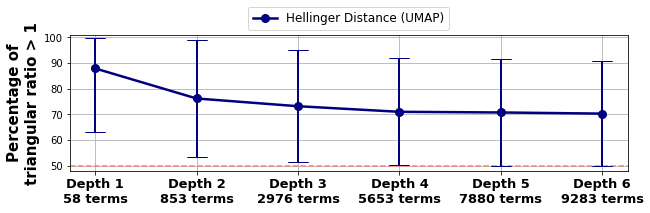

In [22]:
#use df_pca and df_umap to plot the results together
import matplotlib.pyplot as plt

chunk_size = 6
depth_wise_count = depth_wise_count[:chunk_size]
df_pca = df_pca[:chunk_size]
df_umap = df_umap[:chunk_size]

x = ['Depth ' + str(depth + 1) + '\n' + str(each) + ' terms' for depth, each in enumerate(depth_wise_count)]

# Convert relevant data to numpy arrays
x = np.array(x)
df_pca_tvd = np.array(df_pca['tvd'])
df_pca_tvd_std = np.array(df_pca['tvd_std'])
df_pca_tvd_error_max = np.array(df_pca['tvd_error_max'])
df_umap_tvd = np.array(df_umap['tvd'])
df_umap_tvd_std = np.array(df_umap['tvd_std'])
df_umap_tvd_error_max = np.array(df_umap['tvd_error_max'])

df_pca_hld = np.array(df_pca['hld'])
df_pca_hld_std = np.array(df_pca['hld_std'])
df_pca_hld_error_max = np.array(df_pca['hld_error_max'])
df_umap_hld = np.array(df_umap['hld'])
df_umap_hld_std = np.array(df_umap['hld_std'])
df_umap_hld_error_max = np.array(df_umap['hld_error_max'])

fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
ax.axhline(y=50, color='salmon', linestyle='--')


# # Error bounds for Total Variation Distance
# ax.errorbar(x, df_pca_tvd, yerr=[df_pca_tvd_std, df_pca_tvd_error_max], fmt='o', ecolor='firebrick', elinewidth=2, capsize=10, color='firebrick')
# line1, = ax.plot(x, df_pca_tvd, marker='o', color='firebrick', linewidth=2.5, markersize=8, label='Total Variation Distance (PCA)')
# ax.errorbar(x, df_pca_tvd, yerr=[df_pca_tvd_std, df_pca_tvd_error_max], fmt='o', ecolor='firebrick', elinewidth=2, capsize=10, color='firebrick')

# # Error bounds for Hellinger Distance
# ax.errorbar(x, df_pca_hld, yerr=[df_pca_hld_std, df_pca_hld_error_max], fmt='o', ecolor='teal', elinewidth=2, capsize=10, color='teal')
# line3, = ax.plot(x, df_pca_hld, marker='o', color='teal', linewidth=2.5, markersize=8, label='Hellinger Distance (PCA)')
# ax.errorbar(x, df_pca_hld, yerr=[df_pca_hld_std, df_pca_hld_error_max], fmt='o', ecolor='teal', elinewidth=2, capsize=10, color='teal')

# # Error bounds for Total Variation Distance UMAP
# ax.errorbar(x, df_umap_tvd, yerr=[df_umap_tvd_std, df_umap_tvd_error_max], fmt='o', ecolor='darkorange', elinewidth=2, capsize=10, color='darkorange')
# line4, = ax.plot(x, df_umap_tvd, marker='o', color='darkorange', linewidth=2.5, markersize=8, label='Total Variation Distance (UMAP)')
# ax.errorbar(x, df_umap_tvd, yerr=[df_umap_tvd_std, df_umap_tvd_error_max], fmt='o', ecolor='darkorange', elinewidth=2, capsize=10, color='darkorange')

# Error bounds for Hellinger Distance UMAP
ax.errorbar(x, df_umap_hld, yerr=[df_umap_hld_std, df_umap_hld_error_max], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')
line6, = ax.plot(x, df_umap_hld, marker='o', color='navy', linewidth=2.5, markersize=8, label='Hellinger Distance (UMAP)')
ax.errorbar(x, df_umap_hld, yerr=[df_umap_hld_std, df_umap_hld_error_max], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')

ax.grid(True)  # Add gridlines
ax.set_ylabel('Percentage of\ntriangular ratio > 1', fontsize=15, weight='bold')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, fontsize=13, weight='bold')
ax.set_yticks(range(50, 101, 10))  # Set y-axis ticks from 50 to 100 in steps of 10
ax.set_ylim(48, 101)  # Set y-axis limits from 50% to 100%

# # Add annotations for tvd pca
# for i, val in enumerate(df_pca_tvd):
#     val_formatted = '{:.2f}'.format(val)
#     ax.annotate(f'{val_formatted}', (i, val), textcoords="offset points", xytext=(-7, 20), ha='center', fontsize=12, color='black', rotation=90)

# # Add annotations for hld umap
# for i, val in enumerate(df_umap_hld):
#     val_formatted = '{:.2f}'.format(val)
#     ax.annotate(f'{val_formatted}', (i, val), textcoords="offset points", xytext=(-7, -40), ha='center', fontsize=12, color='black', rotation=90)

plt.legend(loc='upper center', fontsize='large', bbox_to_anchor=(0.5, 1.25), ncol=2)  # Add legend
plt.savefig('tvd_hld_umap_pca.png', dpi=300, bbox_inches='tight')
plt.show()